In [1]:
%matplotlib inline
import os
from tqdm import tqdm
import sys
import os
import time
import jax
from jax import lax
from jax import vmap
import jax.numpy as jnp
import jaxopt
import optax
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from jax import jvp, vjp, value_and_grad
from flax import linen as nn
from typing import Sequence
from functools import partial
import scipy
from pyDOE import lhs
import scipy.io as sio

import jax
import jax.numpy as jnp
import jaxopt
from jaxopt import LBFGS

## 1. PINN

In [2]:
from jax import config
config.update("jax_default_matmul_precision", "float32")

In [3]:
# Modified MLP
class PINN(nn.Module):
    degree: int
    features: Sequence[int]
    M:int =10
    def setup(self):
         self.T_funcs = [globals()[f"T{i}"] for i in range(self.degree+1)] 
    @nn.compact
    def __call__(self, t, x):
        init = nn.initializers.glorot_normal()
        X = Fourier_Embedding(degree=self.M)(x) 
        X = jnp.concatenate([t, X], axis=-1)
        U = nn.activation.tanh(nn.Dense(self.features[0], kernel_init=init)(X))
        V = nn.activation.tanh(nn.Dense(self.features[0], kernel_init=init)(X))
        H = nn.activation.tanh(nn.Dense(self.features[0], kernel_init=init)(X))
        for fs in self.features[1:-1]:
            Z = nn.Dense(fs, kernel_init=init)(H)
            Z = nn.activation.tanh(Z)
            H = (jnp.ones_like(Z)-Z)*U + Z*V
        H = nn.Dense(self.features[-1], kernel_init=init)(H)
        return H
@partial(jax.jit, static_argnums=(0,))
def update_model(optim, gradient, params, state):
    updates, state = optim.update(gradient, state)
    params = optax.apply_updates(params, updates)
    return params, state

#Derivatives
def hvp_fwdfwd(f, primals, tangents, return_primals=False):
    g = lambda primals: jvp(f, (primals,), tangents)[1]
    primals_out, tangents_out = jvp(g, primals, tangents)
    if return_primals:
        return primals_out, tangents_out
    else:
        return tangents_out


## 2. Loss Function

In [4]:
@partial(jax.jit, static_argnums=(0,))
def apply_model(apply_fn, params, lambdas, *train_data):
    # Unpack data
    t, x, ti, xi, ui, xb1, xb2, tb, ub = train_data
    def loss_fn(params, lambdas):
        # Compute u
        u = apply_fn(params, t, x)
        # Compute derivatives
        v_t = jnp.ones_like(t)
        v_x = jnp.ones_like(x)
        ut = jvp(lambda t_val: apply_fn(params, t_val, x), (t,), (v_t,))[1]
        uxx = hvp_fwdfwd(lambda x: apply_fn(params, t, x), (x,), (v_x,))
        # Compute residuals
        residuals = ut - 0.0001 * uxx + 5.0 * u ** 3 - 5.0 * u
        # Update lambdas
        r_i = lax.stop_gradient(jnp.abs(residuals))
        new_lambdas = gamma * lambdas + eta * (r_i / jnp.max(r_i))
        # Compute residual loss using updated lambdas
        residual_loss = jnp.mean((new_lambdas  * residuals) ** 2)
        ## ICs Loss:
        u_pred = apply_fn(params, ti, xi)
        ics_loss = jnp.mean((ui-u_pred) ** 2)
        #Total loss:
        loss=residual_loss+100*ics_loss
        return loss, new_lambdas

    # Compute loss and gradient with updated lambdas
    (loss, new_lambdas), gradient = jax.value_and_grad(
        lambda params: loss_fn(params, lambdas), has_aux=True)(params)

    return loss, gradient, new_lambdas


## 3. Hyperparameters

In [5]:
NC=25600
NI=512
NB=512
NC_TEST=100
SEED= 444
EPOCHS=300000
N_LAYERS=6
HIDDEN=128
FEATURES=1
LOG_ITER=1000
degree=20
weight_Cn=1
# random key
key = jax.random.PRNGKey(SEED)
key, subkey = jax.random.split(key, 2)


2024-10-27 02:12:57.120034: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# 4. Load Data

In [6]:
data=scipy.io.loadmat('.../AC.mat')
Exact = data['uu']
Exact0 = np.real(Exact)
t0 = data['tt'].flatten()[:,None]
x0 = data['x'].flatten()[:,None]
T, X = np.meshgrid(t0, x0) 
# Ground Truth
t=T.flatten()[:,None]
x=X.flatten()[:,None]
u_gt=Exact0.flatten()[:,None]
# Collocation points
lb = jnp.array([ t0.min(),x0.min()])
ub = jnp.array([ t0.max(),x0.max()])
X_c= lb + (ub-lb)*lhs(2, NC)
tc=X_c[:,0:1]
xc=X_c[:,1:2]
# Initial conditions
keys = jax.random.split(key, 13)
def ICs(t,x):
    return (x**2)*jnp.cos(jnp.pi*x)
ti = T[:,0:1]
xi = X[:,0:1]
ui = Exact0[:,0:1]
# Boundary Conditions
tb=jax.random.uniform(keys[3], (NB, 1), minval=lb[0], maxval=ub[0])
xb1=tb*0-1
xb2=tb*0+1
ub=xb1*0-1
train_data=tc,xc,ti,xi,ui,xb1,x,t,u_gt
lambdas=tc*0+0.0


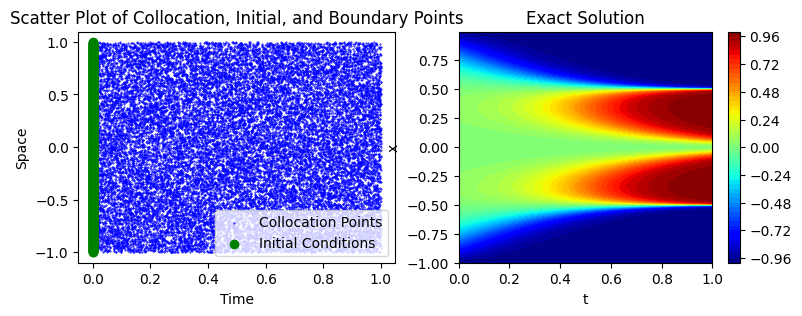

In [7]:
# Plotting code
fig = plt.figure(figsize=(9, 3))

# Scatter plot for collocation, initial, and boundary points
ax1 = fig.add_subplot(121)
ax1.scatter(tc, xc, color='blue', label='Collocation Points',s=0.2)
ax1.scatter(ti, xi, color='green', label='Initial Conditions')
ax1.set_xlabel('Time')
ax1.set_ylabel('Space')
ax1.set_title('Scatter Plot of Collocation, Initial, and Boundary Points')
ax1.legend()

# Surface plot for Exact solution
ax2 = fig.add_subplot(122)
contour = ax2.contourf(T, X, Exact0, cmap='jet', levels=50)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_title('Exact Solution')
plt.show()

## 6. Initialize Model

In [8]:
eta=0.01
gamma=0.999
# force jax to use one device
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

# feature sizes
feat_sizes = tuple([HIDDEN for _ in range(N_LAYERS)] + [FEATURES])
print(feat_sizes)
# make & init model
model = PINN(degree,feat_sizes)
params = model.init(subkey, jnp.ones((NC, 1)), jnp.ones((NC, 1)))

# optimizer
decay_rate=0.9
LR=1e-3
lr0=LR 
lrf=LR/20
decay_step =5000# EPOCHS * jnp.log(decay_rate) / jnp.log(lrf / lr0)
optim = optax.adam(optax.exponential_decay(lr0, decay_step, decay_rate,staircase=False))
state = optim.init(params)

# forward & loss function
apply_fn = jax.jit(model.apply)


total_params = sum(x.size for x in jax.tree_util.tree_leaves(params))
print(total_params )

(128, 128, 128, 128, 128, 128, 1)
91521


## 7. Train

In [9]:
all_errors = []
all_its = []
all_lambdas = []
all_loss = []

start = time.time()
pbar = tqdm(range(1, EPOCHS + 1), desc='Training Progress')

for e in pbar:
    # single run
    loss, gradient, lambdas = apply_model(apply_fn, params, lambdas, *train_data)
    params, state = update_model(optim, gradient, params, state)

    if e % LOG_ITER == 0:
        all_lambdas.append(np.array(lambdas))  # JAX to NumPy conversion
        error = relative_l2_2(apply_fn(params, t, x), u_gt)
        # Updating the tqdm progress bar with loss and other metrics
        pbar.set_description(f"Epoch: {e}/{EPOCHS} | Loss: {loss:.3e} | Error: {error:.3e} | lam_min: {lambdas.min():.3f} | lam_max: {lambdas.max():.3f}")
        all_errors.append(error)
        all_its.append(e)
        all_loss.append(loss)

end = time.time()
print(f'Runtime: {((end - start) / EPOCHS * 1000):.2f} ms/iter.')

Training Progress:   0%|          | 0/300000 [00:00<?, ?it/s]

Epoch: 300000/300000 | Loss: 7.861e-08 | Error: 4.036e-05 | lam_min: 0.015 | lam_max: 9.891: 100%|██████████| 300000/300000 [2:14:24<00:00, 37.20it/s]  

Runtime: 26.88 ms/iter.


## 8. Results

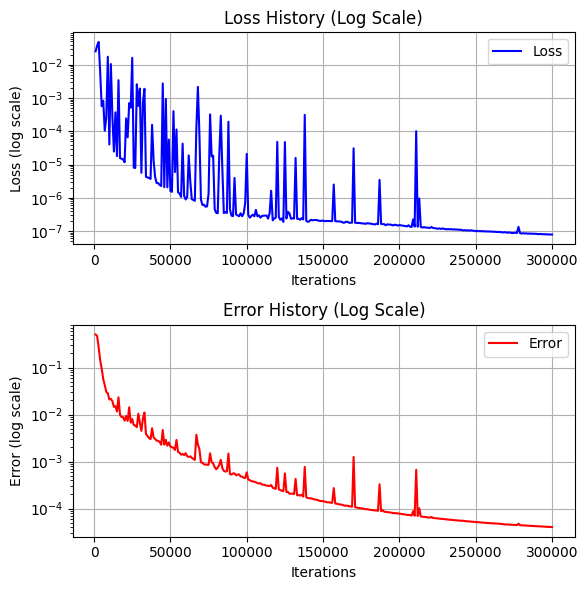

In [10]:
# Adjusting the plot to use a log scale for both loss and error

plt.figure(figsize=(6, 6))

# Plotting loss history with log scale
plt.subplot(2, 1, 1)
plt.plot(all_its, all_loss, label='Loss', color='blue')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Loss (log scale)')
plt.title('Loss History (Log Scale)')
plt.grid(True)
plt.legend()

# Plotting error history with log scale
plt.subplot(2, 1, 2)
plt.plot(all_its, all_errors, label='Error', color='red')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Error (log scale)')
plt.title('Error History (Log Scale)')
plt.grid(True)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [11]:
error = relative_l2(apply_fn(params, t, x), u_gt)
print(f'RL2 error: {error:.8f}') 

RL2 error: 0.00004036


Solution:


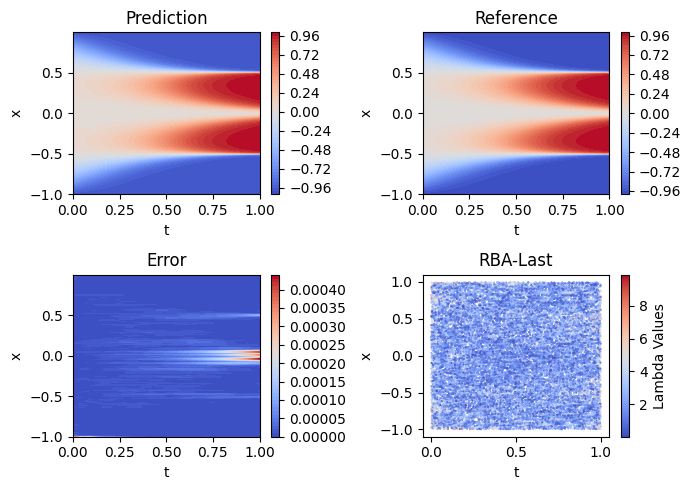

In [13]:
it=-1
print('Solution:')
u = apply_fn(params, t, x)
u = u.reshape(T.shape)
lambdas_grid=all_lambdas[it]
# Plotting code
fig = plt.figure(figsize=(7, 5))
levels=50
# Scatter plot for collocation, initial, and boundary points
ax1 = fig.add_subplot(221)
contour = ax1.contourf(T, X, u, cmap='coolwarm', levels=levels)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.set_title('Prediction')

# Surface plot for Exact solution
ax2 = fig.add_subplot(222)
contour = ax2.contourf(T, X, Exact0, cmap='coolwarm', levels=levels)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_title('Reference')
# Surface plot for Exact solution
ax3 = fig.add_subplot(223)
contour = ax3.contourf(T, X, np.abs(Exact0-u), cmap='coolwarm', levels=levels)  # Filled contour plot with 50 levels
fig.colorbar(contour)  # Add color bar to show scale
ax3.set_xlabel('t')
ax3.set_ylabel('x')
ax3.set_title('Error')
ax4 = fig.add_subplot(224)
scatter = ax4.scatter(tc, xc, c=lambdas_grid, cmap='coolwarm', s=0.1)
cbar = fig.colorbar(scatter, ax=ax4)
cbar.set_label('Lambda Values')
ax4.set_xlabel('t')
ax4.set_ylabel('x')
ax4.set_title('RBA-Last')

plt.tight_layout()
plt.show()

## References

@article{anagnostopoulos2024residual,
  title={Residual-based attention in physics-informed neural networks},
  author={Anagnostopoulos, Sokratis J and Toscano, Juan Diego and Stergiopulos, Nikolaos and Karniadakis, George Em},
  journal={Computer Methods in Applied Mechanics and Engineering},
  volume={421},
  pages={116805},
  year={2024},
  publisher={Elsevier}
}

Link: https://www.sciencedirect.com/science/article/pii/S0045782524000616?dgcid=coauthor
Arxiv: https://arxiv.org/abs/2307.00379


This code was addapted from:

@article{cho2023separable,
  title={Separable Physics-Informed Neural Networks},
  author={Cho, Junwoo and Nam, Seungtae and Yang, Hyunmo and Yun, Seok-Bae and Hong, Youngjoon and Park, Eunbyung},
  journal={Advances in Neural Information Processing Systems},
  year={2023}
}

Github: https://github.com/stnamjef/SPINN

